In [1]:
import numpy as np
import faiss
import os
from utils import fvecs_read, ivecs_read, name2file, readvecs
import pickle
import seaborn as sns
import pandas as pd
import ir_measures as irm
import ir_datasets as ird
import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt

import hyperopt
import lightgbm as lgb
from hyperopt import base
from sklearn.model_selection import train_test_split

from utils import load_msmarco_from_star_vectors, load_msmarco_queries_from_star_vectors, \
    build_ivfindex_from_embeddings, \
    build_index_from_embeddings, load_msmarco_from_contriver, load_msmarco_from_tasb
import seaborn as sns

from functools import cache

In [2]:
print(f'using faiss {faiss.__version__}')

using faiss 1.7.4


In [4]:
sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("ticks",{'axes.grid' : True})
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [6]:
dataset_dir = '/home/busolin/datasets/'
index_dir = '/home/busolin/indexes/'
encoders = ['star', 'contriver', 'tasb']
key2name = {
    'star' : 'STAR',
    'contriver': 'CONTRIEVER',
    'tasb': 'TAS-B'
}
queries = {}
query_ids = {}
embeddings = {}
knn_gt = {}

In [7]:
def load_msmarco(data_dir, encoder='star'):
    if encoder == 'star':
        embs, ids = load_msmarco_from_star_vectors(data_dir)
    if encoder == 'contriver':
        embs, ids = load_msmarco_from_contriver(data_dir)
    if encoder == 'tasb':
        embs, ids = load_msmarco_from_tasb(data_dir)
    return embs, ids

In [8]:
def load_query_embeddings(DATA_DIR, encoder):
    dataset_dev = ird.load('msmarco-passage/dev')
    dataset_small = ird.load('msmarco-passage/dev/small')
    if encoder == 'star':
        query_ids = np.array([int(query.query_id) for query in dataset_dev.queries_iter()])
        query_small_ids = np.array([int(query.query_id) for query in dataset_small.queries_iter()])
        query_embeddings, _ = load_msmarco_queries_from_star_vectors(DATA_DIR, queries='dev-full')
        dev_query_embeddings, _ = load_msmarco_queries_from_star_vectors(DATA_DIR, queries='dev-small')
        return query_embeddings, query_ids, dev_query_embeddings, query_small_ids
    if encoder == 'contriver' or encoder == 'tasb':
        query_ids = np.array([int(query.query_id) for query in dataset_dev.queries_iter()])
        query_small_ids = np.array([int(query.query_id) for query in dataset_small.queries_iter()])
        query_embeddings = np.memmap(DATA_DIR + f'queries_dev.dat', dtype='float32', mode='r').reshape(-1, 768)
        dev_embeddings = np.memmap(DATA_DIR + f'queries_dev-small.dat', dtype='float32', mode='r').reshape(-1, 768)
        return query_embeddings, query_ids, dev_embeddings, query_small_ids

In [9]:
vector_dir = '/home/busolin/dense_data/msmarco/'
dataset_dir = '/home/busolin/datasets/msmarco/'

In [10]:
for encoder in encoders:
    emb_dir = f'{vector_dir}/{encoder}/'
    embeddings[encoder], _ = load_msmarco(emb_dir, encoder)
    queries[encoder] = {}
    query_ids[encoder] = {}
    knn_gt[encoder] = {}
    
    tembs, tids, dembs, dids = load_query_embeddings(emb_dir, encoder)
    queries[encoder]['combined'] = tembs
    query_ids[encoder]['combined'] = tids
    knn_gt[encoder]['combined'] = np.load(f'{dataset_dir}/{encoder}.dev-full_gt_dot.npy')[1, :, :].astype(int)
    
    queries[encoder]['test'] = dembs
    query_ids[encoder]['test'] = dids
    knn_gt[encoder]['test'] = np.load(f'{dataset_dir}/{encoder}.dev-small_gt_dot.npy')[1, :, :].astype(int)

In [11]:
np.all(query_ids['star']['combined'] == query_ids['contriver']['combined']) and np.all( query_ids['contriver']['combined'] == query_ids['tasb']['combined'])

True

In [12]:
np.all(query_ids['star']['test'] == query_ids['contriver']['test']) and np.all( query_ids['contriver']['test'] == query_ids['tasb']['test'])

True

In [ ]:
search_probes = False

In [13]:
qid2offset = {}
offset2qid = {}
qids = query_ids['star']
for split in qids:
    cqids = qids[split]
    offset2qid[split] = {offset : qid for offset,qid in enumerate(cqids)}
    qid2offset[split] = {qid : offset for offset,qid in enumerate(cqids)}

In [14]:
indexes = {}
nclusters = 65535
for encoder in tqdm(encoders):
    marco_name = f'msmarco.{encoder}.IVF{nclusters}.Flat.dot.fidx'    
    marco_index = faiss.read_index(f'{index_dir}/{marco_name}')
    indexes[encoder] = marco_index

100%|█████████████████████████████████████████████| 3/3 [03:07<00:00, 62.55s/it]


In [ ]:
if search_probes:
    minimum_probes = {}
    probe_choices = probe_choices = [1,2,3,4] + [p for p in range(5, 500, 5)] + [w for w in range(500, 1000, 10)] + [q for q in range(1000, 10000, 100)] + [t for t in range(10000, 30000, 1000)] + [r for r in range(30000, 70000, 5000)] + [65535]
    MAX_P = max(probe_choices) + 1
    for encoder in encoders:
        Q = queries[encoder]['combined']
        nq = Q.shape[0]
        GT = knn_gt[encoder]['combined']
        search_mask = np.ones(nq,).astype(bool)
        prev_mask = np.ones(nq,).astype(bool)
        nprobes = np.zeros(nq,).astype(int)
        index = indexes[encoder]
        for p in probe_choices:
            if search_mask.sum() == 0:
                break

            search_queries = Q[search_mask, :]
            search_nn = GT[search_mask]
            faiss.ParameterSpace().set_index_parameter(index, "nprobe", p)
            assert faiss.extract_index_ivf(index).nprobe == p
            search_d, search_items = index.search(search_queries, k=100)
            # failsafe; if found the NN should be in spot #0 but sometimes it is in #1 due to FP errors so we check in (#0, #1, #2) just to be sure (~10 q affected)
            found_mask = np.isin(search_nn[:, 0], search_items[:, :3])
            prev_mask = np.copy(search_mask)
            search_mask[search_mask] = ~found_mask
            nprobes[(prev_mask) & (~search_mask)] = p
            print(' '*80,end='\r')
            print(f'{encoder}: {p} missing {(~found_mask).sum()}', end='\r', flush=True)
        nprobes[nprobes == 0] = MAX_P
        minimum_probes[encoder] = nprobes
    
    with open('data/'+'minprobes_STAR_TASB_CONTRIVER.pkl', 'wb') as savefile:
        pickle.dump(minimum_probes, file=savefile)
else:
    with open('data/'+'minprobes_STAR_TASB_CONTRIVER.pkl', 'rb') as savefile:
        minimum_probes = pickle.load(file=savefile)

In [15]:
qids_dsmall = list(qid2offset['test'].keys())
dsmall_offset = np.array([qid2offset['combined'][qid] for qid in qids_dsmall])
dsmall_mask = np.zeros(shape=(queries['star']['combined'].shape[0],), dtype=bool)
dsmall_mask[dsmall_offset] = True

In [16]:
# sanity check
print(f'total queries={queries["star"]["combined"].shape[0]} | train Q={(~dsmall_mask).sum()} | test Q={dsmall_mask.sum()} | sanity check = {queries["star"]["combined"].shape[0] - (dsmall_mask.sum()) == (~dsmall_mask).sum()}')

total queries=101093 | train Q=94113 | test Q=6980 | sanity check = True


In [17]:
for encoder in encoders:
    queries[encoder]['train'] = (queries[encoder]['combined'])[~dsmall_mask, :]
    query_ids[encoder]['train'] = (query_ids[encoder]['combined'])[~dsmall_mask]
    knn_gt[encoder]['train'] = (knn_gt[encoder]['combined'])[~dsmall_mask, :]

In [18]:
with open('data/'+'minprobes_STAR_TASB_CONTRIVER.pkl', 'rb') as savefile:
    minimum_probes = pickle.load(file=savefile)

In [19]:
@cache
def get_intersections(encoder, x_name, k=2, sk=10):
    if k < 2:
        return np.array([1.0])
    
    x = queries[encoder][x_name]
    index = indexes[encoder]
    intersections = np.zeros(shape=(x.shape[0],(k-1)*2)).astype(float)
    faiss.ParameterSpace().set_index_parameter(index, "nprobe", 1)
    prev_dist, prev_items = index.search(x, k=sk)
    first_dist, first_items = np.copy(prev_dist), np.copy(prev_items)
    for p in tqdm(range(2, k+1)):
        i = (p-2)*2
        j = (p-2)*2 + 1
        faiss.ParameterSpace().set_index_parameter(index, "nprobe", p)
        curr_dist, current_items = index.search(x, k=sk)
        intersection_size = np.sum((prev_items == current_items), axis=1)
        first_intersection_size = np.sum((first_items == current_items), axis=1)
        intersections[:, i] = intersection_size
        intersections[:, j] = first_intersection_size
        prev_dist, prev_items = curr_dist, current_items
    
    
    
    return intersections

In [20]:
def get_features(encoder_name, exit_point=10, search_n=100, include_query=False, include_intersections=False):
    k = 10
    n_intersections = (exit_point -1) * 2 if include_intersections else 0
    n_queries, dim = queries[encoder_name]['combined'].shape
    
    index = indexes[encoder_name]
    encoder_queries = queries[encoder_name]['combined']
    invlists = faiss.extract_index_ivf(index).invlists
    
    faiss.ParameterSpace().set_index_parameter(index, 'nprobe', exit_point)
    sent_d, sent_it = index.search(encoder_queries, search_n)
    
    intersections = get_intersections(encoder_name, 'combined', exit_point, search_n)
    dist_to_centroids, centroid_ids = faiss.extract_index_ivf(index).quantizer.search(encoder_queries, k=100)
    
    feature_block_0 = centroid_interactions = dist_to_centroids[:, range(9, 109, 10)] * (1 / dist_to_centroids[:, 0]).reshape((n_queries, 1))
    
    f0 = sent_d[:, 0]
    f1 = sent_d[:, k - 1]
    f2 = f0 / f1
    f3 = f0 / dist_to_centroids[:, 0]
    
    feature_block_1 = distance_features = np.hstack([f0, f1, f2, f3]).reshape((-1, 4))
    feature_block_2 = k_centroid_distances = dist_to_centroids[:, :k]
    
    n_queryFeatures = dim if include_query else 0
    n_conditional_features = n_intersections + n_queryFeatures
    
    print(feature_block_0.shape, feature_block_1.shape, feature_block_2.shape)
    
    n_features =  n_conditional_features + feature_block_0.shape[1] + feature_block_1.shape[1] + feature_block_2.shape[1]
    
    
    feature_blocks = [feature_block_0, feature_block_1, feature_block_2]
    features = np.zeros(shape=(n_queries, n_features), dtype=float)
    
    if include_query:
        features[:, :dim] = encoder_queries
    if include_intersections:
        features[:, n_queryFeatures:n_queryFeatures+n_intersections] = intersections * (1/search_n)
    
    used_features = n_conditional_features
    
    for feature_block in feature_blocks:
        features[:, used_features:used_features + feature_block.shape[1]] = feature_block
        used_features = used_features + feature_block.shape[1]
    
    
    query_names_cb0 = [f'Qfeat#{i}' for i in range(dim)]
    inter_names_cb1 = []
    for i in range(1, exit_point):
        inter_names_cb1.append(f'inter clust #{i} - clust #{i-1}')
        inter_names_cb1.append(f'inter clust #0 - clust #{i}')
    
    centint_names_b0 = [f'd cent#{x:>3} / d cent#0' for x in range(9, 109, 10)]
    feature_block_names_b1 = ['d item#0', f'd item#{k-1}', f'd item#0 / d item#{k-1}', f'd item#0 / d cent#0' ]
    centroid_names_b2 = [f'd cent#{x}' for x in range(k)]
    
    cond_names = []
    cond_names = cond_names + query_names_cb0 if include_query else cond_names
    cond_names = cond_names + inter_names_cb1 if include_intersections else cond_names
    
    
    feature_names = cond_names + centint_names_b0 + feature_block_names_b1 + centroid_names_b2
    
    return features, feature_names

In [21]:
def get_params_space(num_boost_round=1500, num_leaves=[64], max_depth=[8] ,early_stopping_rounds=100):
    
    # parameters space
    params_space = {
        'learning_rate': hyperopt.pyll.base.scope.maximum(
            hyperopt.hp.quniform("learning_rate", 10, 100, 5) / 100,
            0.1
        ),
        'num_leaves': hyperopt.hp.choice('num_leaves', num_leaves),
        'max_depth': hyperopt.hp.choice('max_depth', max_depth),
        
        'min_data_in_leaf': hyperopt.hp.quniform('min_data_in_leaf', 10, 10000, 10),
        
        'min_sum_hessian_in_leaf': hyperopt.pyll.base.scope.maximum(
            hyperopt.hp.quniform('min_sum_hessian_in_leaf', 1, 1e5, 100) / 1000,
            0.001
        ),
        
        'lambda_l1': hyperopt.pyll.base.scope.maximum(
            hyperopt.hp.quniform('lambda_l1', 0, 100, 2) / 10,
            0.1
        ),

        'lambda_l2': hyperopt.pyll.base.scope.maximum(
            hyperopt.hp.quniform('lambda_l2', 0, 100, 2) / 10,
            0.0
        ),
        
        'min_gain_to_split': hyperopt.pyll.base.scope.maximum(
            hyperopt.hp.quniform('min_gain_to_split', 0, 100, 2) / 10,
            0.0
        ),
        
        'boosting_type': 'gbdt',
        'early_stopping_rounds': early_stopping_rounds,
        'num_boost_round': num_boost_round,
        'feature_pre_filter': False,
        'verbosity' : -100
    }
    
    return params_space

In [22]:
def get_clf_lgb_objective(lgb_datasets, metric, debug=None):

    def lgb_objective(p):
        try:
            params, other = get_clf_lgb_parameters(p)
            num_stop_rounds = other.pop("early_stopping_rounds")

            evals_result = {}
            lgb_model = lgb.train(
                params, 
                lgb_datasets['train'],
                valid_sets=[lgb_datasets['vali']],
                valid_names=['vali'],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=num_stop_rounds),
                ],
                **other
            )

            
            loss = lgb_model.best_score['vali'][metric]
            
            # debug
            if debug is not None:
                if "valid_loss" not in debug or debug["valid_loss"] is None or debug["valid_loss"] > loss:
                    debug["p"] = p
                    debug["params"] = params
                    debug["other"] = other
                    debug["valid_loss"] = loss

                    debug["model"] = lgb_model
                    debug["num_trees"] = lgb_model.best_iteration

            return {
                "loss": loss,
                "status": hyperopt.STATUS_OK
            }

        except Exception as e:
            print(e)
            return {
                "status": hyperopt.STATUS_FAIL,
                "exception": str(e)
            }

    return lgb_objective

In [23]:
def get_reg_lgb_objective(lgb_datasets, metric, debug=None):

    def lgb_objective(p):
        try:
            params, other = get_reg_lgb_parameters(p)
            num_stop_rounds = other.pop("early_stopping_rounds")

            evals_result = {}
            lgb_model = lgb.train(
                params, 
                lgb_datasets['train'],
                valid_sets=[lgb_datasets['vali']],
                valid_names=['vali'],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=num_stop_rounds),
                ],
                **other
            )

            
            loss = lgb_model.best_score['vali'][metric]
            
            # debug
            if debug is not None:
                if "valid_loss" not in debug or debug["valid_loss"] is None or debug["valid_loss"] > loss:
                    debug["p"] = p
                    debug["params"] = params
                    debug["other"] = other
                    debug["valid_loss"] = loss

                    debug["model"] = lgb_model
                    debug["num_trees"] = lgb_model.best_iteration

            return {
                "loss": loss,
                "status": hyperopt.STATUS_OK
            }

        except Exception as e:
            print(e)
            return {
                "status": hyperopt.STATUS_FAIL,
                "exception": str(e)
            }

    return lgb_objective

In [24]:
def get_clf_lgb_parameters(p):
    # parameters to cast
    for p_name in ["min_data_in_leaf", "num_leaves", "max_position", "eval_at"]:
        if p_name in p:
            p[p_name] = int(p[p_name])

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        #'max_position': 10,
        'metric': 'binary_logloss',
    }
    params.update(**p)

    other = {}
    if "num_boost_round" in params:
        other["num_boost_round"] = params.pop("num_boost_round")
    else:
        other["num_boost_round"] = 1000

    if "early_stopping_rounds" in params:
        other["early_stopping_rounds"] = params.pop("early_stopping_rounds")
    else:
        other["early_stopping_rounds"] = 100

    return params, other

In [25]:
def get_reg_lgb_parameters(p):
    # parameters to cast
    for p_name in ["min_data_in_leaf", "num_leaves", "max_position", "eval_at"]:
        if p_name in p:
            p[p_name] = int(p[p_name])

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        #'max_position': 10,
        'metric': 'l2',
    }
    params.update(**p)

    other = {}
    if "num_boost_round" in params:
        other["num_boost_round"] = params.pop("num_boost_round")
    else:
        other["num_boost_round"] = 1000

    if "early_stopping_rounds" in params:
        other["early_stopping_rounds"] = params.pop("early_stopping_rounds")
    else:
        other["early_stopping_rounds"] = 100

    return params, other

In [26]:
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, BorderlineSMOTE

In [27]:
def train_clf(X, Y, weight, n_regressors=[20], fnames=None):
    data = [('train', X['train'] , Y['train']), ('vali', X['vali'], Y['vali']), ('test', X['test'], Y['test'])]

    lgb_datasets = dict([
        (dataset_name, lgb.Dataset(data=X, label=y, feature_name=fnames ,weight=(1+ weight*((y.astype(bool)).astype(int))))) 
    for dataset_name, X, y in data
    ])
    
    lgb_enc = lgb_datasets
    opt_res = {}
    results = {}
    for num_trees in n_regressors:
        params_space = get_params_space(num_boost_round=num_trees, num_leaves=[64], max_depth=[8], early_stopping_rounds=5)
        # trials object to track progress
        bayes_trials = hyperopt.Trials()
        opt_res[num_trees] = {}
        # optimize
        np.random.seed(42)
        best = hyperopt.fmin(
            fn=get_clf_lgb_objective(lgb_enc, metric='binary_logloss', debug=opt_res[num_trees]),
            space=params_space,
            algo=hyperopt.tpe.suggest,
            max_evals=NUM_TRIALS,
            trials=bayes_trials,
            rstate=np.random.default_rng(42)
        )
        results[num_trees] = {
            'best_params': hyperopt.space_eval(params_space, best),
        }
    return opt_res

In [28]:
def train_regressor(X, Y, n_regressors=[20], fnames=None):
    data = [('train', X['train'] , Y['train']), ('vali', X['vali'], Y['vali']), ('test', X['test'], Y['test'])]

    reg_lgb_datasets = dict([
        (dataset_name, lgb.Dataset(data=X, label=y, feature_name=frnames)) 
    for dataset_name, X, y in data
    ])
    
    enc_data = reg_lgb_datasets
    reg_opt_res = {}
    reg_results = {}
    for num_trees in n_regressors:
        params_space = get_params_space(num_boost_round=num_trees, num_leaves=[64], max_depth=[8], early_stopping_rounds=5)
        # trials object to track progress
        bayes_trials = hyperopt.Trials()
        reg_opt_res[num_trees] = {}
        # optimize
        np.random.seed(42)
        best = hyperopt.fmin(
            fn=get_reg_lgb_objective(enc_data, metric='l2', debug=reg_opt_res[num_trees]),
            space=params_space,
            algo=hyperopt.tpe.suggest,
            max_evals=NUM_TRIALS,
            trials=bayes_trials,
            rstate=np.random.default_rng(42),
        )
        reg_results[num_trees] = {
            'best_params': hyperopt.space_eval(params_space, best),
        }
    return reg_opt_res

In [29]:
sentinel_positions = [2, 10]
instance_weights = [1, 3, 5, 7]
n_regressors = [20,50, 100]
use_inter_values = [True, False]
ignore_low_reg = [True, False]
NUM_TRIALS = 100
training_models = False
saving_models = False
loading_models = True

In [30]:
if training_models:
    classifiers = {}
    regressors = {}
    X = {}
    Y = {}
    for encoder in encoders:
        classifiers[encoder] = {}
        regressors[encoder] = {}
        X[encoder] = {}
        Y[encoder] = {}
        for exit_point in sentinel_positions:
            classifiers[encoder][exit_point] = {}
            regressors[encoder][exit_point] = {}
            X[encoder][exit_point] = {}
            Y[encoder][exit_point] = {}
            for use_query in use_inter_values: # misnomer; correct use. FIX Welcomed
                classifiers[encoder][exit_point][use_query] = {}
                regressors[encoder][exit_point][use_query] = {}
                X[encoder][exit_point][use_query] = {}
                Y[encoder][exit_point][use_query] = {}

                Xc, feat_names =  get_features(encoder, exit_point=exit_point, search_n=100, include_query=True, include_intersections=use_query)
                Yc = (minimum_probes[encoder] > exit_point).astype(int)
                
                print(f'*** Using {Xc.shape[1]} Features ***')
                
                
                Xc_test = Xc[dsmall_mask]
                Yc_test = Yc[dsmall_mask]

                Xc_trainvali = Xc[~dsmall_mask]
                Yc_trainvali = Yc[~dsmall_mask]

                Xc_resampled, Yc_resampled = SMOTE().fit_resample(Xc_trainvali, Yc_trainvali)
                Xc_train, Xc_vali, Yc_train, Yc_vali = train_test_split(Xc_resampled, Yc_resampled, test_size=0.33, random_state=42)

                Xc_dict = {
                    'train': Xc_train,
                    'test': Xc_test,
                    'vali': Xc_vali
                }
                Yc_dict =  {
                    'train': Yc_train,
                    'test': Yc_test,
                    'vali': Yc_vali
                }
                X[encoder][exit_point][use_query]['clf'] = Xc_dict
                Y[encoder][exit_point][use_query]['clf'] = Yc_dict


                for instance_weight in instance_weights:
                    clf = train_clf(Xc_dict, Yc_dict, instance_weight, n_regressors, fnames=feat_names)
                    classifiers[encoder][exit_point][use_query][instance_weight] = clf

                Xr, frnames = get_features(encoder, exit_point=exit_point, search_n=100, include_query=True, include_intersections=use_query)
                Xr_dict = {}
                Yr_dict = {}
                for ignore_before in ignore_low_reg:
                    mpr = minimum_probes[encoder].astype(int)
                    ignore_mask = mpr > exit_point if ignore_before else mpr >= 0 
                    Yr = mpr
                    
                    Xr_test = Xr[dsmall_mask]
                    Yr_test = Yr[dsmall_mask]

                    Xr_trainvali = (Xr[~dsmall_mask])[ignore_mask[~dsmall_mask]]
                    Yr_trainvali = (Yr[~dsmall_mask])[ignore_mask[~dsmall_mask]]

                    Xr_train, Xr_vali, Yr_train, Yr_vali = train_test_split(Xr_trainvali, Yr_trainvali, test_size=0.33, random_state=42)

                    Xr_dict[ignore_before] = {
                        'train': Xr_train,
                        'test': Xr_test,
                        'vali': Xr_vali
                    }
                    Yr_dict[ignore_before] = {
                        'train': Yr_train,
                        'test': Yr_test,
                        'vali': Yr_vali
                    }
                    X[encoder][exit_point][use_query]['reg'] = Xr_dict
                    Y[encoder][exit_point][use_query]['reg'] = Yr_dict


                    regr = train_regressor(Xr_dict[ignore_before], Yr_dict[ignore_before], n_regressors, fnames=frnames)
                    regressors[encoder][exit_point][use_query][ignore_before] = regr

In [31]:
print('done')

done


In [32]:
print('models trained!')

models trained!


In [33]:
import pickle
if saving_models:
    with open('data/'+'all_classifiers_with_query.pkl', mode='wb') as cf:
        pickle.dump(classifiers, file=cf)
    with open('data/'+'all_regressors_with_query.pkl', mode='wb') as rf:
        pickle.dump(regressors, file=rf)

    with open('data/'+'all_feats_with_query.pkl', mode='wb') as rf:
        pickle.dump(X, file=rf)

    with open('data/'+'all_labels_with_query.pkl', mode='wb') as rf:
        pickle.dump(Y, file=rf)

In [34]:
import pickle
if loading_models:
    with open('data/'+'all_classifiers_with_query.pkl', mode='rb') as cf:
        classifiers = pickle.load(file=cf)

    with open('data/'+'all_regressors_with_query.pkl', mode='rb') as rf:
        regressors = pickle.load( file=rf)

    with open('data/'+'all_feats_with_query.pkl', mode='rb') as rf:
        X = pickle.load(file=rf)

    with open('data/'+'all_labels_with_query.pkl', mode='rb') as rf:
        Y = pickle.load(file=rf)

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

In [39]:
def intersect1d_padded(x):
    x, y = np.split(x, 2)
    padded_intersection = -1 * np.ones(x.shape, dtype=int)
    intersection = np.intersect1d(x, y)
    padded_intersection[:intersection.shape[0]] = intersection
    return padded_intersection

def rowwise_intersection(a, b):
    return np.apply_along_axis(intersect1d_padded, 1, np.concatenate((a, b), axis=1))

In [40]:
@cache
def search_index(encoder, split, nprobes, k):
    index = indexes[encoder]
    q = queries[encoder][split]
    faiss.ParameterSpace().set_index_parameter(index, "nprobe", nprobes)
    return index.search(q, k)

In [41]:

def get_probes_by_patience(encoder_name, split ,search_mask, patience=5, tol=0.95, min_p=1, max_p=100, sk=100):
    dataset_queries = queries[encoder_name][split]
    index = indexes[encoder_name]
    nq = dataset_queries.shape[0]
    pat_probes = np.zeros(shape=(nq,),dtype=int)
    patience_mask = np.zeros(nq) - 1
    
    for p in range(min_p, max_p+1):
        if search_mask.sum() == 0:
                break
        
        probe_distances, probe_search = search_index(encoder_name, split, p, sk)
        
        search_queries = dataset_queries[search_mask]
        
        
        current_dist, current_search = probe_distances[search_mask], probe_search[search_mask]

        if p == min_p:
            prev_search = current_search
            prev_mask = np.copy(search_mask)

        intersection_size = np.sum((current_search == prev_search), axis=1).astype(float)
        over_tol_mask = (intersection_size/sk) >= tol

        pat_mask = patience_mask[search_mask]
        pat_mask[over_tol_mask] = pat_mask[over_tol_mask] + 1
        pat_mask[~over_tol_mask] = 0

        patience_mask[search_mask] = pat_mask
        next_mask = (patience_mask[search_mask] < patience )

        search_mask[search_mask] = next_mask
        pat_probes[(~search_mask & (pat_probes == 0))] = p

        prev_search = current_search[next_mask]
    
    pat_probes[search_mask] = max_p
    return pat_probes

In [42]:
def evaluate(encoder, probes, reference_dataset, r_cutoff=1, rr_cutoff=10):
    index = indexes[encoder]
    dataset_queries = queries[encoder]['test']
    dataset_gt = knn_gt[encoder]['test']
    nq = dataset_queries.shape[0]
    pat_probes = probes
    dict_qrels = reference_dataset.qrels.asdict()
    cost = 0
    recall = np.zeros(nq,).astype(bool)
    rev_recall = np.zeros(nq,).astype(bool)
    rev_recall_cut = np.zeros(nq,).astype(bool)
    rev_recall_top = np.zeros(nq,).astype(bool)
    rr = np.zeros(nq).astype(float)
    rr_cut = np.zeros(nq).astype(float)
    for p in np.unique(pat_probes):
        
        search_mask = (pat_probes == p)
        
        if search_mask.sum() == 0:
            break

        probe_distances, probe_search = search_index(encoder, 'test', int(p), 100)
        
        search_queries = dataset_queries[search_mask]
        searching_offsets = search_mask.nonzero()[0]
        search_gt = dataset_gt[search_mask, 0]

        
        search_dist, search_items = probe_distances[search_mask], probe_search[search_mask]

        rec = np.isin(search_gt, search_items)

        searched_qids = [offset2qid['combined'][soff] for soff in dsmall_offset[searching_offsets]]
        searched_rels = [list(dict_qrels[str(sqid)].keys()) for sqid in searched_qids]
        for search_offset in range(search_items.shape[0]):
            query_offset = searching_offsets[search_offset]
            query_rel = searched_rels[search_offset]
            query_rel = np.array(query_rel).astype(int)
            if pat_probes[query_offset] == p: # safety barrier
                rel_positions = np.where( query_rel.reshape(query_rel.size, 1) == search_items[search_offset])
                rr_of_rel = 1 / ( 1 + rel_positions[1]) if (rel_positions[1].size) > 0 else [0]
                query_rr = max(rr_of_rel)
                query_r = rec[search_offset]
                cost = cost + p
                recall[query_offset] = query_r
                rr[query_offset] = query_rr 
                rr_cut[query_offset] = query_rr if query_rr > (1/rr_cutoff) else 0.0
                rev_recall[query_offset] = query_rr > 0
                rev_recall_cut[query_offset] = query_rr > (1/rr_cutoff)
                rev_recall_top[query_offset] = query_rr > 0.9
        
    return (recall.astype(float), 
            rev_recall.astype(float),
            rev_recall_cut.astype(float),
            rev_recall_top.astype(float), 
            rr_cut.astype(float), 
            rr.astype(float), 
            float(cost))

In [43]:
import pandas as pd

In [44]:
msmarco = ird.load("msmarco-passage/dev/small")
max_p95 = {'star': 80, 'contriver': 140, 'tasb': 190}

In [45]:
def experiment(encoder_name, 
               exit_point, 
               instance_weight, 
               intersection_features, 
               query_features, 
               use_clf, 
               conf_thr, 
               use_reg, 
               ignore_reg, 
               patience, tol):
    
    index = indexes[encoder_name]
    nq = queries[encoder_name]['test'].shape[0] 
    max_probe = max_p95[encoder_name]
    clf = classifiers[encoder_name][exit_point][intersection_features][instance_weight][100]['model']
    reg = regressors[encoder_name][exit_point][intersection_features][ignore_reg][100]['model']
    probes = np.zeros(shape=(nq,),dtype=int)
    continue_q = np.ones(shape=(nq,), dtype=bool)
#     print(f'Use intersection features {intersection_features} at s = {exit_point} ', end='')
    if patience > 0 and use_reg:
        print('INVALID!')
        return []
    
    if use_clf and conf_thr > 0:
#         print(f'CLF w={instance_weight} t={conf_thr} in use ', end='')
        x = X[encoder_name][exit_point][intersection_features]['clf']['test']
        clf_pred = clf.predict(x)
        continue_q = clf_pred >= conf_thr
        probes[~continue_q] = exit_point
    
    if use_reg:
#         print(f'REG ignoring before sentinel {ignore_reg} in use')
        x = X[encoder_name][exit_point][intersection_features]['reg'][ignore_reg]['test']
        reg_pred = reg.predict(x)
        reg_pred = np.round(np.clip(reg_pred, exit_point, max_probe)).astype(int)
        probes[continue_q] = reg_pred[continue_q]
    
    elif patience > 0:
#         print(f'PATIENCE {patience} tol {tol} in use')
        probes[continue_q] = get_probes_by_patience(encoder_name, 'test', np.copy(continue_q), patience, tol, exit_point, max_probe, 100)[continue_q]
    else:
#         print(f'FIXED k={max_probe} in use')
        probes[continue_q] = max_probe
    
#     print((probes == 0).sum())
    
    return evaluate(encoder, probes, msmarco, r_cutoff=1, rr_cutoff=10)

In [46]:
if False:
    int_opts = [True, False]
    qopts = [True]
    use_regressor = [True, False]
    use_classifier = [True, False]
    patiences = [0, 3, 5, 7, 10, 12, 14]
    clf_thr = [0.3, 0.4, 0.5, 0.6]
    tols = [0.9, 0.95, 1.00]
    results = []
    tot_exps = len(encoders)*len(sentinel_positions)*len(instance_weights)*len(int_opts)*len(qopts) * len(use_classifier)*len(clf_thr)*((len(use_regressor)*len(ignore_low_reg))+(len(patiences)*len(tols)))
    with tqdm(total=tot_exps) as pbar:
        for encoder in encoders:
            for sentinel_position in sentinel_positions:
                for iweight in instance_weights:
                    for use_intersection in int_opts:
                        for use_query_features in qopts:
                            for clf_active in use_classifier:
                                for conf_threshold in clf_thr:
                                    for reg_active in use_regressor:
                                        for ignored in ignore_low_reg:
                                            res = experiment(encoder, sentinel_position, iweight, use_intersection, use_query_features, clf_active, conf_threshold, reg_active, ignored, 0, 0)
                                            results.append(((encoder, sentinel_position, iweight, use_intersection, use_query_features, clf_active, conf_threshold, reg_active, ignored, 0, 0), res))
                                            pbar.update(1)
                                    for patience in patiences:
                                        for tolerance in tols:
                                            res = experiment(encoder, sentinel_position, iweight, use_intersection, use_query_features, clf_active, conf_threshold, False, False, patience, tolerance)
                                            results.append(((encoder, sentinel_position, iweight, use_intersection, use_query_features, clf_active, conf_threshold, False, False, patience, tolerance), res))
                                            pbar.update(1)


In [47]:
if False:
    rows = []
    for result in tqdm(results):
        options, values = result 
        # recall, rev_recall, rev_recall_cut, rev_recall_top, rr_cut, rr, cost = values
        averages = []
        for value in values:
            averages.append(np.mean(value))

        row = list(options) + averages
        rows.append(row)

In [49]:
if False:
    df = pd.DataFrame(rows, columns=['Encoder', 'Exit Point', 'Instance Weight', 'Interaction Features', 'query Features', 'Use Classifier', 'Classifier Threshold', 'Use Regressor', 'Ignore low values', 'Patience', 'Tolerance', 'R_nn', 'R@100', 'R@10', 'R@1', 'MRR@10', 'MRR', 'Cost'])
else:
    df = pd.read_csv('data/experiments.all.raw.dataframe.csv', )

In [52]:
df = df.drop_duplicates(subset=['Cost', 'R_nn'], keep='last')

In [715]:
Ik = {True: 'I', False:'NI'}
for encoder in encoders:
    for exit_point in classifiers[encoder]:
        for use_intersection in [True, False]:
            reg = regressors[encoder][exit_point][use_intersection][False][100]['model']
            reg.save_model(f'models/R.{encoder}.S-{exit_point}.I-{Ik[use_intersection]}.D-100.txt')
            for iw in classifiers[encoder][exit_point][use_intersection]:
                clf = classifiers[encoder][exit_point][use_intersection][iw][100]['model']
                clf.save_model(f'./models/C.{encoder}.S-{exit_point}.I-{Ik[use_intersection]}.W-{iw}.D-100.txt')

In [52]:
for encoder in ['tasb']:
    search_queries = queries[encoder]['test']
    index = indexes[encoder]
    faiss.ParameterSpace().set_index_parameter(index, "nprobe", 1)
    continue_mask = Y[encoder][10][True]['clf']['test'].astype(bool)
    current = index.search(search_queries, k=100)
    first = current
    results = []
    intersections = []
    intersection_with_first = []
    intersections_C = []
    intersection_with_first_C = []
    intersections_E = []
    intersection_with_first_E = []
    for p in tqdm(range(2, 100, 1)):
        prev = current 
        search_queries = queries[encoder]['test']
        faiss.ParameterSpace().set_index_parameter(index, "nprobe", p)
        current = index.search(search_queries, k=100)
        intersect = rowwise_intersection(prev[1],current[1])
        intersect1 = rowwise_intersection(first[1], current[1])
        
        intersections.append(intersect)
        intersection_with_first.append(intersect1)
        
        intersect_c = rowwise_intersection(prev[1][continue_mask],current[1][continue_mask])
        intersect1_c = rowwise_intersection(first[1][continue_mask], current[1][continue_mask])
        
        intersect_e = rowwise_intersection(prev[1][~continue_mask],current[1][~continue_mask])
        intersect1_e = rowwise_intersection(first[1][~continue_mask], current[1][~continue_mask])
        
        intersections_C.append(intersect_c)
        intersections_E.append(intersect_e)
        
        intersection_with_first_C.append(intersect1_c)
        intersection_with_first_E.append(intersect1_e)
        
        results.append(current)

100%|███████████████████████████████████████████| 98/98 [05:17<00:00,  3.24s/it]


In [276]:
intersections = np.array(intersections)
intersections_C = np.array(intersections_C)
intersections_E = np.array(intersections_E)
intersection_with_first = np.array(intersection_with_first)
intersection_with_first_C = np.array(intersection_with_first_C)
intersection_with_first_E = np.array(intersection_with_first_E)
results = np.array(results)

/tmp/ipykernel_107989/1144749791.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[1].set_yticklabels(['']*len([item.get_text() for item in axis[1].get_xticklabels()]))


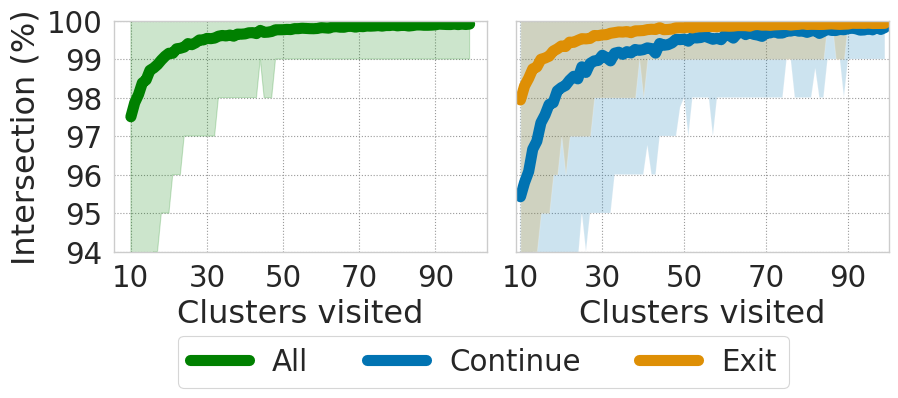

In [365]:
inter_plotting = (intersections > 0).sum(axis=2)
y_est = inter_plotting.mean(axis=1)
y_err = inter_plotting.std(axis=1)
y_p25 = np.percentile(inter_plotting, 5, axis=1)
y_p75 = np.percentile(inter_plotting, 95, axis=1)


plotting_C = (intersections_C > 0).sum(axis=2)
plotting_E = (intersections_E > 0).sum(axis=2)
yest_C = plotting_C.mean(axis=1)
y_Cp25 = np.percentile(plotting_C, 5, axis=1)
y_Cp75 = np.percentile(plotting_C, 95, axis=1)
yest_E = plotting_E.mean(axis=1)
y_Ep25 = np.percentile(plotting_E, 5, axis=1)
y_Ep75 = np.percentile(plotting_E, 95, axis=1)


with sns.plotting_context('paper',font_scale=2.40):
    fig, axis = plt.subplots(1, 2, figsize=(10, 3))
    
    sns.lineplot(x=range(10, 100, 1), y=y_est[8:],linewidth=8, ax=axis[0], c='g', label='All')
    sns.lineplot(x=range(10, 100, 1), y=yest_C[8:],linewidth=8, label='Continue', ax=axis[1])
    sns.lineplot(x=range(10, 100, 1), y=yest_E[8:],linewidth=8, label='Exit', ax=axis[1])
    
    axis[0].fill_between(range(10, 100, 1), y_p25[8:], y_p75[8:], alpha=0.2, interpolate=True, color='g') # y_est - y_err, np.clip(y_est + y_err, 0, 100)
    axis[1].fill_between(range(10, 100, 1), y_Cp25[8:], y_Cp75[8:], alpha=0.2, interpolate=True)
    axis[1].fill_between(range(10, 100, 1), y_Ep25[8:], y_Ep75[8:], alpha=0.2, interpolate=True)
    
    
    
    
    axis[0].set_xlabel('Clusters visited')
    axis[1].set_xlabel('Clusters visited')
    axis[0].set_ylabel('Intersection (%)')
    axis[0].set_ylim(94, 100)
    axis[1].set_ylim(94, 100)
    plt.xlim(9, 100)
    axis[0].set_xticks(np.arange(10, 101, 20))
    axis[1].set_xticks(np.arange(10, 101, 20))
    h1, l1 = axis[0].get_legend_handles_labels()
    h2, l2 = axis[1].get_legend_handles_labels()
    axis[1].legend([], frameon=False)
    axis[0].legend(h1+h2, l1+l2, bbox_to_anchor=(1.85, -0.30), ncol=3)
    axis[1].set_yticklabels(['']*len([item.get_text() for item in axis[1].get_xticklabels()]))
    plt.subplots_adjust(wspace=0.08, hspace=0)
    plt.savefig(f'data/intersize_only.pdf', bbox_inches='tight')